# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [93]:
# Use this space for any additional import statements you need
import warnings
import matplotlib.pyplot as plt

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# Descriptive Stats function
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # Print the five most common tokens
        top_five = Counter(tokens).most_common(5)
        print(top_five)
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

# Checks if contains emojis
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)

# Removes stopwords
def remove_stop(tokens) :
    
    tokens = [word for word in tokens if word not in sw]
    
    return(tokens)
 
# Removes punctuation
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

# Tokenizes the test
def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return text.split()

# Applies the pipeline
def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

# Removes the song title from the lyrics
def remove_title(text):
   
    # Song title is found before the first \n
    lyrics = text.split('\n', 1)[1]
            
    return lyrics

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Data location
data_location = "/Users/clairebentzen/Desktop/MDAS/ADS 509 - Applied Text Mining/Module 2/Assignment2.1/M1 Results/"

# Subfolders data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

# Specify artist_files for twitter data
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [5]:
# Read cher twitter data
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
# Read robyn twitter data
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

# Concat twitter dataframes
twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# Read in the lyrics data
# Specify pathway to lyrics folder
lyrics_path = data_location + lyrics_folder

# Create a dataframe to store results
lyrics_data = pd.DataFrame(columns=['artist', 'song', 'lyrics'])

# Iterate through each file in the lyrics folder
for artist in os.listdir(lyrics_path):
    artist_path = os.path.join(lyrics_path, artist)
    
    # Iterate through each file in the artist folders
    for song in os.listdir(artist_path):
        song_path = os.path.join(artist_path, song)
        rem_prefix = song.removeprefix(f'{artist}_')
        song_title = rem_prefix.removesuffix('.txt')

        # Open and read the contents of the file (song)
        with open(song_path, 'r') as file:
            contents = file.read()
            # Prepare data to add to dataframe
            data = {'artist': artist, 'song': song_title, 'lyrics': contents}
            # The df.append() function is deprecated, so we will ignore warnings here
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                # Append row of data to lyrics_df
                lyrics_data = lyrics_data.append(data, ignore_index=True)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# Initialize pipeline to remove title, casefold, remove sw, remove punctuation, and split lyrics
lyrics_pipeline = [remove_title, str.lower, remove_punctuation, tokenize, remove_stop]

# Initialize pipeline to casefold, remove sw, remove punctuation, and split twitter descriptions
twitter_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Apply pipeline to lyrics
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, pipeline=lyrics_pipeline)
# Calculate number of tokens in each row
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

# Apply pipeline to twitter descriptions
twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=twitter_pipeline)
# Calculate number of tokens in each row
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [9]:
# Check which twitter descriptions have emojis
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [10]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
362581,cher,13 👍 single 💙 loves photography 📷 loves Englis...,"[13, 👍, single, 💙, loves, photography, 📷, love..."
539461,cher,#resist #StartingOverAgain 🙄,"[#resist, #startingoveragain, 🙄]"
2637504,cher,I'm a nice gal. Co-founder of Barkpass 🐾 and B...,"[im, nice, gal, cofounder, barkpass, 🐾, barret..."
286294,cher,Artist🎶🎸 Musician young chimzy,"[artist🎶🎸, musician, young, chimzy]"
96236,cher,Argentina 🇦🇷 Amo los michis 🐱 Musica 🎵 Harry P...,"[argentina, 🇦🇷, amo, los, michis, 🐱, musica, 🎵..."
42216,robyn,⚡️⚡️⚡️,[⚡️⚡️⚡️]
256106,cher,#JustBeWhoYouWannaBe 🏳️‍🌈 #StandWithUkraine Sp...,"[#justbewhoyouwannabe, 🏳️‍🌈, #standwithukraine..."
1945186,cher,"Don't look back, you're not going that way✨","[dont, look, back, youre, going, way✨]"
35901,cher,˚✧･.｡･☂︎︎｡☠︎︎｡･˚✧❦˳✧☦︎︎༚☁︎︎✧༚･☆｡𓂀｡☆༒･☕︎︎𖠌☀︎︎ﾟh...,[˚✧･｡･☂︎︎｡☠︎︎｡･˚✧❦˳✧☦︎︎༚☁︎︎✧༚･☆｡𓂀｡☆༒･☕︎︎𖠌☀︎︎ﾟh...
2150633,cher,dog mom # Jeter❤️,"[dog, mom, #, jeter❤️]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One area of improvement I could perform on my tokenization has to do with the emojis. It appears that the emojis are only tokenized individually if there are spaces between them. If an emoji is next to another emoji or other character, then the emoji will not be a separate token. Ideally, each emoji should be its own token regardless of if there is a space next to it or not.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [102]:
# Cher Lyrics Stats
# Subset cher lyrics
cher_lyrics = lyrics_data[lyrics_data['artist'] == 'cher']
# Concat cleaned lyrics into one string
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cher_lyrics['cleaned_lyrics'] = cher_lyrics['tokens'].apply(lambda x: ' '.join(x))
cher_lyrics_str = cher_lyrics['cleaned_lyrics'].str.cat(sep=' ')

# Calculate descriptive stats
cher_lyrics_desc = descriptive_stats(cher_lyrics_str.split())
cher_lyrics_desc

There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
[('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332)]


[35233, 3684, 0.10456106491073709, 169244]

In [103]:
# Robyn Lyrics Stats
# Subset robyn lyrics
robyn_lyrics = lyrics_data[lyrics_data['artist'] == 'robyn']
# Concat cleaned lyrics into one string
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    robyn_lyrics['cleaned_lyrics'] = robyn_lyrics['tokens'].apply(lambda x: ' '.join(x))
robyn_lyrics_str = robyn_lyrics['cleaned_lyrics'].str.cat(sep=' ')

# Calculate descriptive stats
robyn_lyrics_desc = descriptive_stats(robyn_lyrics_str.split())
robyn_lyrics_desc

There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
[('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249)]


[15041, 2139, 0.1422112891430091, 72804]

Q: what observations do you make about these data? 

A: The Cher lyrics contain more tokens, unique tokens, and characters, but the lexical diversity is slighly lower than the Robyn lyrics. An interesting observation is that out of the top 5 most common words, these two artists share 4 of them, although they are in different orders. These 4 words they have in common are love, know, im, and dont.

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [104]:
# Get Twitter description strings
# Subset cher twitter
cher_twitter = twitter_data[twitter_data['artist'] == 'cher']
# Concat cleaned descriptions into one string
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cher_twitter['cleaned_description'] = cher_twitter['tokens'].apply(lambda x: ' '.join(x))
cher_twitter_str = cher_twitter['cleaned_description'].str.cat(sep=' ')

# Subset robyn twitter
robyn_twitter = twitter_data[twitter_data['artist'] == 'robyn']
# Concat cleaned descriptions into one string
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    robyn_twitter['cleaned_description'] = robyn_twitter['tokens'].apply(lambda x: ' '.join(x))
robyn_twitter_str = robyn_twitter['cleaned_description'].str.cat(sep=' ')

In [48]:
# Initialize CountVectorizer
cv = CountVectorizer()

# Combine each document into one list
documents = [cher_lyrics_str, robyn_lyrics_str, cher_twitter_str, robyn_twitter_str]

# Bag of words 
bow = cv.fit_transform(documents)

# Tokens from each document
tokens = cv.get_feature_names_out()

# Token frequencies
token_freq = bow.toarray()

# Convert token frequencies into dataframe
bow_df = pd.DataFrame(bow.toarray(), columns=tokens)

# Transpose df
bow_df = bow_df.T

# New column names
column_names = ['c1', 'c2', 'c3', 'c4']

# Set new column names
bow_df.columns = column_names
bow_df

In [61]:
# Calculate corpus token totals
c1_total = sum(cher_lyrics['num_tokens'])
c2_total = sum(robyn_lyrics['num_tokens'])
c3_total = sum(cher_twitter['num_tokens'])
c4_total = sum(robyn_twitter['num_tokens'])

In [62]:
# Specify list of total columns to iterate through
c_totals = {
    1: c1_total,
    2: c2_total,
    3: c3_total,
    4: c4_total
}

# Add concentration columns to df
for i in range(1,5):
    total = c_totals[i]
    bow_df[f'concentration{i}'] = bow_df[f'c{i}'] / total

In [65]:
# Set cutoff point
cutoff = 5

# Add binary column to signal whether a row passes the cutoff
bow_df['pass_cutoff'] = (
    (bow_df['c1'] > cutoff) &
    (bow_df['c2'] > cutoff) &
    (bow_df['c3'] > cutoff) &
    (bow_df['c4'] > cutoff)
).astype(int)

In [68]:
# Reduce df to tokens that meet the cutoff criteria
cutoff_df = bow_df[bow_df['pass_cutoff'] == 1]

In [75]:
# Ratio of each corpus compared to the next highest one
for i in range(1, 5):
    # Store current column name
    col_name = f'concentration{i}'
    # Calculate max concentration that does not equal the concentration in the numerator
    max_con = cutoff_df[[f'concentration{j}' for j in range(1, 5) if j != i]].max(axis=1)
    # Compute the ratio for the current column compared to the max concentration
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cutoff_df[f'ratio{i}'] = cutoff_df[col_name] / max_con

In [84]:
# Corpus 1 - Cher Lyrics Top Tokens
top_c1 = cutoff_df.sort_values(by='ratio1', ascending=False)
top_c1.head(10)

,c1,c2,c3,c4,concentration1,concentration2,concentration3,concentration4,pass_cutoff,ratio1,ratio2,ratio3,ratio4
enough,124,7,4741,313,0.003519,0.000465,0.000268,0.000188,1,7.562245,0.132236,0.076246,0.053443
find,135,6,10440,956,0.003832,0.000399,0.000591,0.000574,1,6.484314,0.104110,0.154218,0.149930
man,201,12,16783,1496,0.005705,0.000798,0.000950,0.000899,1,6.005611,0.139849,0.166511,0.157580
believe,139,11,11645,661,0.003945,0.000731,0.000659,0.000397,1,5.394475,0.185375,0.167068,0.100682
well,163,16,9927,751,0.004626,0.001064,0.000562,0.000451,1,4.349053,0.229935,0.121451,0.097548
hope,56,6,6698,400,0.001589,0.000399,0.000379,0.000240,1,3.984409,0.250978,0.238521,0.151230
home,102,11,12803,735,0.002895,0.000731,0.000725,0.000442,1,3.958536,0.252619,0.250312,0.152564
last,48,6,4716,314,0.001362,0.000399,0.000267,0.000189,1,3.415207,0.292808,0.195930,0.138501
night,170,22,4979,681,0.004825,0.001463,0.000282,0.000409,1,3.298780,0.303142,0.058407,0.084813
sleep,54,7,2463,242,0.001533,0.000465,0.000139,0.000145,1,3.293236,0.303653,0.090958,0.094883


In [85]:
# Corpus 2 - Robyn Lyrics Top Tokens
top_c2 = cutoff_df.sort_values(by='ratio2', ascending=False)
top_c2.head(10)

,c1,c2,c3,c4,concentration1,concentration2,concentration3,concentration4,pass_cutoff,ratio1,ratio2,ratio3,ratio4
beat,17,144,1582,243,0.000483,0.009574,0.000090,0.000146,1,0.050398,19.842047,0.009353,0.015252
hang,8,35,1926,92,0.000227,0.002327,0.000109,0.000055,1,0.097577,10.248280,0.046847,0.023758
dance,25,148,10403,1608,0.000710,0.009840,0.000589,0.000966,1,0.072112,10.183172,0.059840,0.098201
shake,6,18,397,50,0.000170,0.001197,0.000022,0.000030,1,0.142300,7.027392,0.018776,0.025107
alright,10,30,613,55,0.000284,0.001995,0.000035,0.000033,1,0.142300,7.027392,0.017395,0.016570
pretend,6,15,606,59,0.000170,0.000997,0.000034,0.000035,1,0.170760,5.856160,0.034394,0.035551
space,8,20,3599,378,0.000227,0.001330,0.000204,0.000227,1,0.170760,5.853904,0.153196,0.170826
lets,20,47,5322,515,0.000568,0.003125,0.000301,0.000309,1,0.181660,5.504790,0.096399,0.099038
fit,7,16,1465,116,0.000199,0.001064,0.000083,0.000070,1,0.186769,5.354203,0.077950,0.065529
set,21,44,1618,171,0.000596,0.002925,0.000092,0.000103,1,0.203748,4.908020,0.031306,0.035127


In [86]:
# Corpus 3 - Cher Twitter Top Tokens
top_c3 = cutoff_df.sort_values(by='ratio3', ascending=False)
top_c3.head(10)

,c1,c2,c3,c4,concentration1,concentration2,concentration3,concentration4,pass_cutoff,ratio1,ratio2,ratio3,ratio4
proud,9,7,31774,1230,0.000255,0.000465,0.001798,0.000739,1,0.142037,0.258779,2.433159,0.410988
god,31,6,24565,860,0.000880,0.000399,0.001390,0.000517,1,0.632813,0.286905,1.580245,0.371687
life,124,39,126569,7564,0.003519,0.002593,0.007164,0.004545,1,0.491275,0.361944,1.576085,0.634484
happy,24,6,18901,1096,0.000681,0.000399,0.001070,0.000659,1,0.636733,0.372881,1.570517,0.615633
old,34,6,29477,1834,0.000965,0.000399,0.001668,0.001102,1,0.578397,0.239096,1.513867,0.660560
people,44,22,38416,2558,0.001249,0.001463,0.002174,0.001537,1,0.574343,0.672689,1.414540,0.706943
news,8,6,16656,1143,0.000227,0.000399,0.000943,0.000687,1,0.240852,0.423140,1.372550,0.728571
friends,21,16,25607,1491,0.000596,0.001064,0.001449,0.000896,1,0.411236,0.733947,1.362495,0.618180
best,10,6,26792,1876,0.000284,0.000399,0.001516,0.001127,1,0.187165,0.263057,1.345166,0.743402
trying,29,7,17019,1014,0.000823,0.000465,0.000963,0.000609,1,0.854466,0.483134,1.170322,0.632558


In [87]:
# Corpus 4 - Robyn Twitter Top Tokens
top_c4 = cutoff_df.sort_values(by='ratio4', ascending=False)
top_c4.head(10)

,c1,c2,c3,c4,concentration1,concentration2,concentration3,concentration4,pass_cutoff,ratio1,ratio2,ratio3,ratio4
music,32,29,90283,15372,0.000908,0.001928,0.005110,0.009237,1,0.098323,0.208725,0.553196,1.807676
new,34,29,34388,3649,0.000965,0.001928,0.001946,0.002193,1,0.440088,0.879289,0.887640,1.126583
things,57,18,30112,2952,0.001618,0.001197,0.001704,0.001774,1,0.911996,0.674627,0.960787,1.040814
working,9,9,12768,1155,0.000255,0.000598,0.000723,0.000694,1,0.353468,0.827987,1.041225,0.960407
making,17,8,8748,826,0.000483,0.000532,0.000495,0.000496,1,0.907164,1.071562,0.930926,0.933217
black,25,6,11812,1014,0.000710,0.000399,0.000669,0.000609,1,1.061322,0.562191,0.942221,0.858743
big,31,8,17115,1316,0.000880,0.000532,0.000969,0.000791,1,0.908271,0.549056,1.100993,0.816348
best,10,6,26792,1876,0.000284,0.000399,0.001516,0.001127,1,0.187165,0.263057,1.345166,0.743402
news,8,6,16656,1143,0.000227,0.000399,0.000943,0.000687,1,0.240852,0.423140,1.372550,0.728571
people,44,22,38416,2558,0.001249,0.001463,0.002174,0.001537,1,0.574343,0.672689,1.414540,0.706943


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: One interesting observation is that the token 'people' is on the top 10 list for both Cher and Robyn Twitter descriptions. Another interesting observation is that the top 10 tokens from Robyn lyrics have a very high ratio compared to the other ratios, meaning these words are very unique to Robyn's lyrics. While the ratios for Cher lyrics tokens are high too, they are not nearly as high as Robyn. Additionally, the ratios for the top tokens in the twitter descriptions for both artists are fairly low, meaning these words are also pretty common in the other corpus'. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [83]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

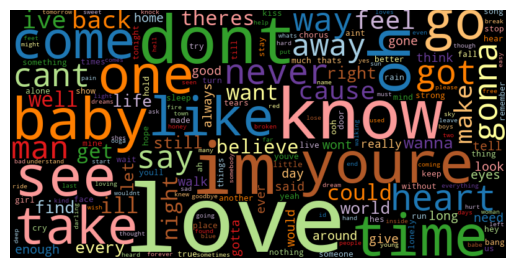

In [98]:
# Cher Lyrics Wordcloud
c1_df = count_words(cher_lyrics)
wordcloud(c1_df['freq'])

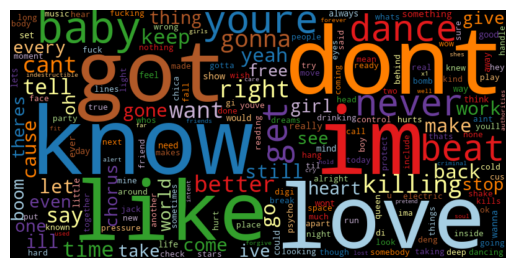

In [99]:
# Robyn Lyrics Wordcloud
c2_df = count_words(robyn_lyrics)
wordcloud(c2_df['freq'])

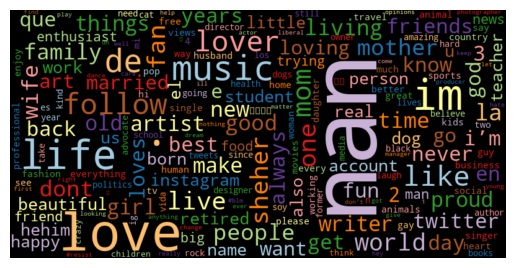

In [100]:
# Cher Twitter Wordcloud
c3_df = count_words(cher_twitter)
wordcloud(c3_df['freq'])

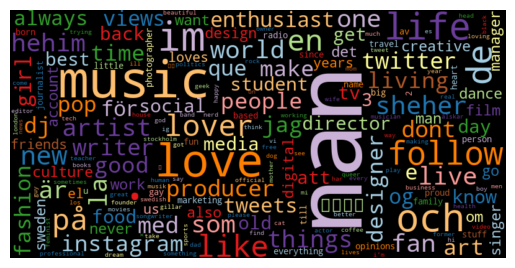

In [101]:
# Robyn Twitter Wordcloud
c4_df = count_words(robyn_twitter)
wordcloud(c4_df['freq'])

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The Twitter description wordclouds both include nan as tokens (signifying blank descriptions), which are the most prevalent in the wordcloud. Ideally these would be removed. The token 'love' is found in all four wordclouds. Overall, the two lyrics wordclouds look fairly similar to each other and the two Twitter description wordclouds look fairly similar to each other. 